loop = 1Change = 0.2 c = 372.21502527842773 densité struct = 0.3297993868409301
loop = 2Change = 0.20000000000000007 c = 186.36128212034203 densité struct = 0.3299771362025116
loop = 3Change = 0.20000000000000007 c = 116.65591840667909 densité struct = 0.3299732371725104
loop = 4Change = 0.20000000000000007 c = 76.71604420803045 densité struct = 0.3299202310740881
loop = 5Change = 0.20000000000000007 c = 53.58893390183285 densité struct = 0.33001192370971993
loop = 6Change = 0.20000000000000007 c = 42.90979509075602 densité struct = 0.33001768828876193
loop = 7Change = 0.20000000000000007 c = 37.15364380591896 densité struct = 0.33001774684907886
loop = 8Change = 0.20000000000000007 c = 34.088065745240065 densité struct = 0.3300260544022119
loop = 9Change = 0.20000000000000007 c = 32.495841701757435 densité struct = 0.33001625065386564
loop = 10Change = 0.14863043123195208 c = 31.70431042837993 densité struct = 0.3300007617233691
loop = 11Change = 0.14256918141693325 c = 31.15423621592

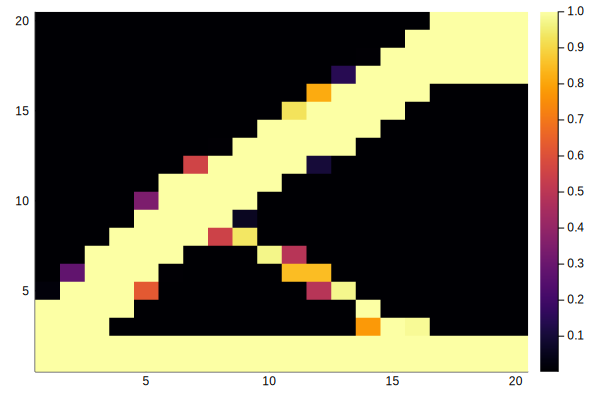

In [1]:
#top88 applied on a different example -> changes are lines 30 and 32
using SparseArrays
using LinearAlgebra
using Plots
using Statistics
using SuiteSparse
E0 = 1;
Emin = 1e-9;
nu = 0.3;
function top88_2(nelx,nely,volfrac,penal,rmin,ft)
        
    A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12]
    A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6]
    B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4]
    B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2]
    KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11])

    nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx); #number of the nodes in columns
    edofVec = reshape(2*nodenrs[1:end-1,1:end-1].+1,nelx*nely,1) ;#1st dof of each element (x top left)
    edofMat = zeros(nelx*nely, 8); #every line i contains the 8 dof of the ith element
    noeudsvoisins = [0 1 2*nely.+[2 3 0 1] -2 -1];
    for i = 1:8
        for j = 1:nelx*nely
            edofMat[j,i]= edofVec[j]+ noeudsvoisins[i] ;
        end
    end
    #maillage
    iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);# line to build  K
    jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);# columns
    F = zeros(2*(nely+1)*(nelx+1),1); F[2,1] = 1; #new stress
    U = zeros(2*(nely+1)*(nelx+1),1);
    fixeddofs = (2*nelx*(nely+1)+1):2*(nelx+1)*(nely+1); #new dofs fixed : right side, direction y
    alldofs = 1:2*(nely+1)*(nelx+1);
    freedofs = setdiff(alldofs,fixeddofs);
    #filtering is linear + chain's rule -> matricial opration with operator H
    iH = ones(nelx*nely*(2*convert(Int64,ceil(rmin)-1)+1)^2);#lines H
    jH = ones(size(iH));# columns
    sH = zeros(size(iH));# values
    k = 0;
    for i1 = 1:nelx
        for j1 = 1:nely
            e1 = (i1-1)*nely+j1;
            for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
                for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
                    e2 = (i2-1)*nely+j2;
                    k = k+1;
                    iH[k] = e1;
                    jH[k] = e2;
                    sH[k] = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
                end
            end
        end
    end
    H = sparse(iH,jH,sH);# matrix of the Hei
    Hs = [sum(H[i,:]) for i = 1:(size(H)[1])];# sum of the Hei for e fixed -> coeffs used to divide in the filter
    #variables
    x = volfrac*ones(nely,nelx);
    xPhys = x;#new variable for the density filter
    loop = 0;
    change = 1;
    cValues = []
    while change > 0.01
        loop = loop + 1;
        sK = [j*((i+Emin)^penal) for i in ((E0-Emin)*xPhys[:]') for j in KE[:] ];#new values EF
        K = sparse(iK[:],jK[:],sK); K = (K+K')/2;# force to be symmetric
        KK = cholesky(K[freedofs,freedofs]);
        U[freedofs] = KK\F[freedofs];
        
        # analyse, objective function
        edM = [convert(Int64,i) for i in edofMat] ;#to index by int
        mat = (U[edM]*KE).*U[edM];
        ce = reshape([sum(mat[i,:]) for i = 1:(size(mat)[1])],nely,nelx);
        c = sum(sum((Emin*ones(size(xPhys)).+(xPhys.^penal)*(E0-Emin)).*ce));
        push!(cValues,c)
        dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
        dv = ones(nely,nelx);
        
        #filtering
        if ft == 1
            dc[:] = H*(x[:].*dc[:])./Hs./max(1e-3,maximum(x[:]));
        elseif ft == 2
            dc[:] = H*(dc[:]./Hs);
            dv[:] = H*(dv[:]./Hs);
        end
        #Lagrangian multiplicators research, upload of the density x
        l1 = 0; l2 = 1e9; move = 0.2;
        xnew = zeros(nely, nelx);
        while (l2-l1)/(l1+l2) > 1e-3
            lmid = 0.5*(l2+l1);
            RacBe = sqrt.(-dc./dv/lmid) ;
            XB = x.*RacBe ;
            for i = 1:nelx
                for j = 1:nely
                    xji = x[j,i];
                    xnew[j,i]= max(0.001,max(xji-move,min(1,min(xji+move,XB[j,i]))));
                end
            end  
            if ft == 1
                xPhys = xnew;
            elseif ft == 2 # if we choose the density filter
                xPhys[:] = (H*xnew[:])./Hs;
            end
            if sum(xPhys[:]) > volfrac*nelx*nely
                l1 = lmid;
            else 
                l2 = lmid; 
            end
        end
        change = maximum(abs.(x-xnew));
        x = xnew;
        println("loop = ", loop, "Change = ", change ," c = ", c , " densité struct = ", mean(x) )
        if loop == 35
            return heatmap(x), loop, cValues
        end
    end
    return heatmap(x) , loop , cValues
end
h,l,c = top88_2(20,20,0.33,3,1.5,1);
h #plotting the final aspect

loop = 1Change = 0.2 c = 2525.4871109386836 densité struct = 0.3299998117589151
loop = 2Change = 0.2 c = 613.8753419305825 densité struct = 0.33003689430764327
loop = 3Change = 0.2 c = 310.81911710408747 densité struct = 0.3299347075803897
loop = 4Change = 0.20000000000000007 c = 220.0559851572844 densité struct = 0.32990154280392103
loop = 5Change = 0.20000000000000007 c = 181.41289711154806 densité struct = 0.330055113811854
loop = 6Change = 0.20000000000000007 c = 165.4156168236457 densité struct = 0.32996580472091636
loop = 7Change = 0.18250303948589996 c = 155.77507075904353 densité struct = 0.3299398733280087
loop = 8Change = 0.19999999999999996 c = 149.0200712996785 densité struct = 0.32995382879592355
loop = 9Change = 0.18774276663443767 c = 143.2007772734915 densité struct = 0.3299684738367521
loop = 10Change = 0.13539419422235854 c = 139.17053152173955 densité struct = 0.32998005231216554
loop = 11Change = 0.13138426719306973 c = 136.72958769262232 densité struct = 0.32995880

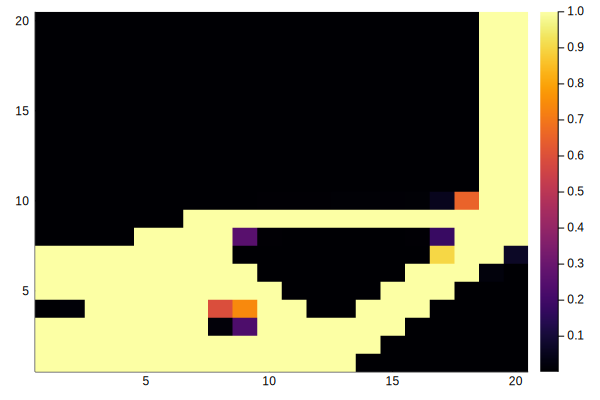

In [2]:
#adding passive nodes to force them to have no material -> whole created
# see changes lines 49 to 58 and 97 to 99
function top88_gap(nelx,nely,volfrac,penal,rmin,ft)
        
    A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12]
    A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6]
    B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4]
    B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2]
    KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11])

    nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx); #number of the nodes in columns
    edofVec = reshape(2*nodenrs[1:end-1,1:end-1].+1,nelx*nely,1) ;#1st dof of each element (x top left)
    edofMat = zeros(nelx*nely, 8); #every line i contains the 8 dof of the ith element
    noeudsvoisins = [0 1 2*nely.+[2 3 0 1] -2 -1];
    for i = 1:8
        for j = 1:nelx*nely
            edofMat[j,i]= edofVec[j]+ noeudsvoisins[i] ;
        end
    end
    #maillage
    iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);# line to build  K
    jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);# columns
    F = zeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1;
    U = zeros(2*(nely+1)*(nelx+1),1);
    fixeddofs = union(1:2:2*(nely+1),[2*(nelx+1)*(nely+1)]);
    alldofs = 1:2*(nely+1)*(nelx+1);
    freedofs = setdiff(alldofs,fixeddofs);
    iH = ones(nelx*nely*(2*convert(Int64,ceil(rmin)-1)+1)^2);#lines H
    jH = ones(size(iH));# columns
    sH = zeros(size(iH));# values
    k = 0;
    for i1 = 1:nelx
        for j1 = 1:nely
            e1 = (i1-1)*nely+j1;
            for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
                for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
                    e2 = (i2-1)*nely+j2;
                    k = k+1;
                    iH[k] = e1;
                    jH[k] = e2;
                    sH[k] = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
                end
            end
        end
    end
    H = sparse(iH,jH,sH);# matrix of the Hei
    Hs = [sum(H[i,:]) for i = 1:(size(H)[1])];# sum of the Hei for e fixed -> coeffs used to divide in the filter
    #variables with the empty nodes tahnks to "passive"
    passive = []
    x = volfrac*ones(nely,nelx);
    for ex = 1:nelx
        for ey = 1:nely
            if (ex^2 + (ey-nely)^2)< (0.65*nelx)^2
                push!(passive,(ey,ex) )
                x[ey,ex]= 0.001
            end
        end
    end
    xPhys = x;#new variable for the density filter
    loop = 0;
    change = 1;
    cValues = []
    while change > 0.01
        loop = loop + 1;
        sK = [j*((i+Emin)^penal) for i in ((E0-Emin)*xPhys[:]') for j in KE[:] ];#new values EF
        K = sparse(iK[:],jK[:],sK); K = (K+K')/2;# force to be symmetric
        KK = cholesky(K[freedofs,freedofs]);
        U[freedofs] = KK\F[freedofs];
        edM = [convert(Int64,i) for i in edofMat] ;#to index by int
        mat = (U[edM]*KE).*U[edM];
        ce = reshape([sum(mat[i,:]) for i = 1:(size(mat)[1])],nely,nelx);
        c = sum(sum((Emin*ones(size(xPhys)).+(xPhys.^penal)*(E0-Emin)).*ce));
        push!(cValues,c)
        dc = -penal*(E0-Emin)*xPhys.^(penal-1).*ce;
        dv = ones(nely,nelx);
        
        #filtering
        if ft == 1
            dc[:] = H*(x[:].*dc[:])./Hs./max(1e-3,maximum(x[:]));
        elseif ft == 2
            dc[:] = H*(dc[:]./Hs);
            dv[:] = H*(dv[:]./Hs);
        end
        #Lagrangian multiplicators research, upload of the density x
        l1 = 0; l2 = 1e9; move = 0.2;
        xnew = zeros(nely, nelx);
        while (l2-l1)/(l1+l2) > 1e-3
            lmid = 0.5*(l2+l1);
            RacBe = sqrt.(-dc./dv/lmid) ;
            XB = x.*RacBe ;
            for i = 1:nelx
                for j = 1:nely
                    xji = x[j,i];
                    xnew[j,i]= max(0.001,max(xji-move,min(1,min(xji+move,XB[j,i]))));
                end
            end  
            for coord in passive #force to keep a whole
                x[coord[1],coord[2]]= 0.001
            end
            if ft == 1
                xPhys = xnew;
            elseif ft == 2 # if we choose the density filter
                xPhys[:] = (H*xnew[:])./Hs;
            end
            if sum(xPhys[:]) > volfrac*nelx*nely
                l1 = lmid;
            else 
                l2 = lmid; 
            end
        end
        change = maximum(abs.(x-xnew));
        x = xnew;
        println("loop = ", loop, "Change = ", change ," c = ", c , " densité struct = ", mean(x) )
        if loop == 35
            return heatmap(x), loop, cValues
        end
    end
    return heatmap(x) , loop , cValues
end
h,l,c = top88_gap(20,20,0.33,3,1.5,1);
h #plotting the final aspect